In [1]:
# Goal: Estimate [Ca II]/[O I] ratio at different epochs and compare against different supernovae
# 
# Ca is not as sensitive to differing ZAMS mass, so could point towards very massive or not progenitor
# However the ratio changes over time, so not quite the golden gun either
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model
import snelib19odp.gaussian as gaussian
import snelib19odp.utils as utils
import snelib19odp.specsmooth as specsmooth

In [2]:
sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {
        'max_width': 20,
        'scale_factor': np.sqrt(2)/3.031557125203086e-18, 
        'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,
    })
}


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



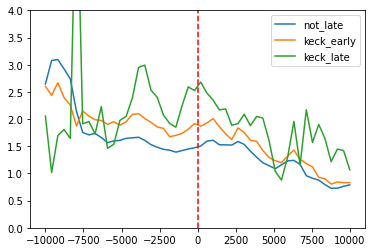

In [4]:
for spec_name in SPECS.keys():
    spec, _ = SPECS[spec_name]
    spec = specsmooth.downsample(spec, 4)
    wave = spec['restwave'][::-1]
    flux = spec['flux'][::-1]
    idx = ~np.isnan(flux)
    wave = wave[idx]
    flux = flux[idx]
    
    velocity_oxygen = oxygen.line2velocity(6300, wave)
    velocity_calcium = oxygen.line2velocity(7292, wave)
    
    v_grid = np.linspace(-10e3, 10e3)
    f_oxygen = np.interp(v_grid, velocity_oxygen, flux)
    f_calcium = np.interp(v_grid, velocity_calcium, flux)
    #print(f_oxygen/f_calcium)
    plt.plot(v_grid, f_oxygen/f_calcium, label=spec_name)
plt.legend()
plt.ylim((0, 4));
plt.axvline(0, ls='--', color='red')

In [19]:
# just calculate the simplistic integral fashion
for spec_name in SPECS.keys():
    spec, _ = SPECS[spec_name]
    #spec = specsmooth.downsample(spec, 2)
    wave = spec['restwave'][::-1]
    flux = spec['flux'][::-1]
    idx = ~np.isnan(flux)
    wave = wave[idx]
    flux = flux[idx]
    
    velocity_oxygen = oxygen.line2velocity(6300, wave)
    velocity_calcium = oxygen.line2velocity(7292, wave)
    
    idx1 = np.abs(velocity_oxygen) < 8000
    idx2 = np.abs(velocity_calcium) < 8000
    f_oxygen = np.trapz(flux[idx1], wave[idx1])
    f_calcium = np.trapz(flux[idx2], wave[idx2])
    print(spec_name, f_oxygen/f_calcium)

not_late 1.2491029604588966
keck_early 1.498980923186733
keck_late 1.8624461162866819
